In [0]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import tensorflow as tf
import numpy as np
import re

from glob import glob
import pickle as pkl
import scipy.misc

import time

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

do_preprocess = False
from_checkpoint = True

In [0]:
def load_glove(data_dir_path=None,embedding_dim=None):
  
  
  word2em={}
  
  file=open(data_dir_path,mode='rt',encoding='utf8')
  for line in file:
    words=line.strip().split()
    word=words[0]
    embeds=np.array(words[1:],dtype=np.float32)
    word2em[word]=embeds
  file.close()
  
  return word2em


def txt_2_wordembedding(line,word_em):
  x=re.sub(r"(?<!\\)\\n|\n", "", line)
  x1=x.lower().split()
  embedding_list=[]
  text_list=[]
  for i in range(4):
    if i > 1:
      text_list.append(x1[i].lstrip())
      embedding_list.append(word_em[x1[i].lstrip()])

  return(text_list,embedding_list)



  
def read_resize(path,filename):
    img=os.path.join(path,filename)
    img=cv2.imread(img)
    res=cv2.resize(img, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    return res


def image_batch_generator(batch_size,Image_path,text_path,word_em):
  

    idx = np.arange(1 , 1819)
    np.random.shuffle(idx)
    idx=idx[:batch_size]
    Images=[]
    text_list=[]
    Embedding_list=[]
    for name in idx:
      
      #image
      filename=str(name)+'.jpg'
      image=read_resize(Image_path,filename)
      Images.append(image)

      
      
      #text
      with open(text_path) as fp:
        for i, line in enumerate(fp):
          if i == name:
            text,Embedding=txt_2_wordembedding(line,word_em)
      
      text_list.append(text)
      EM=np.asarray(Embedding)

      EM=np.reshape(EM,200)
      Embedding_list.append(EM)
    
    
    Embedding_list=np.asarray(Embedding_list)  
    Images = np.array(Images, dtype=np.float32)
    Images/=255.0
    
    return Images,Embedding_list,text_list
  
  
def save_snapshots(generated_images,snap_shot_dir,epoch):
  generated_images = cv2.cvtColor(generated_images, cv2.COLOR_BGR2RGB)
  scipy.misc.imsave(os.path.join(snap_shot_dir, epoch + ".jpg"), generated_images)
  

  


In [0]:
def model_inputs(real_dim, z_dim,txt_dim):

    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    inputs_txt= tf.placeholder(tf.float32,(None,txt_dim),name='Txt_Em')
    learning_rate_G = tf.placeholder(tf.float32, name="learning_rate_G")
    learning_rate_D = tf.placeholder(tf.float32, name="learning_rate_D")
    
    return inputs_real, inputs_z, inputs_txt, learning_rate_G, learning_rate_D

In [0]:
def generator(z, output_channel_dim, text, is_train=True):

    with tf.variable_scope("generator", reuse= not is_train):
        
        reduced_text_embedding= tf.layers.dense(text,100)
        reduced_text_embedding = tf.nn.leaky_relu(reduced_text_embedding, alpha=alpha)
        

        z_concat = tf.concat([z, reduced_text_embedding],1)
        # First FC layer --> 8x8x1024
        fc1 = tf.layers.dense(z_concat, 8*8*1024)
        
        # Reshape it
        fc1 = tf.reshape(fc1, (-1, 8, 8, 1024))
        
        # Leaky ReLU
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)

        
        # Transposed conv 1 --> BatchNorm --> LeakyReLU
        # 8x8x1024 --> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs = fc1,
                                  filters = 512,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv1")
        
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1, training=is_train, epsilon=1e-5, name="batch_trans_conv1")
       
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1, alpha=alpha, name="trans_conv1_out")
        
        
        # Transposed conv 2 --> BatchNorm --> LeakyReLU
        # 16x16x512 --> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs = trans_conv1_out,
                                  filters = 256,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv2")
        
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2, training=is_train, epsilon=1e-5, name="batch_trans_conv2")
       
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2, alpha=alpha, name="trans_conv2_out")
        
        
        # Transposed conv 3 --> BatchNorm --> LeakyReLU
        # 32x32x256 --> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs = trans_conv2_out,
                                  filters = 128,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv3")
        
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3, training=is_train, epsilon=1e-5, name="batch_trans_conv3")
       
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3, alpha=alpha, name="trans_conv3_out")

        
        # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs = trans_conv3_out,
                                  filters = 64,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv4")
        
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4, training=is_train, epsilon=1e-5, name="batch_trans_conv4")
       
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4, alpha=alpha, name="trans_conv4_out")

        
                # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv5 = tf.layers.conv2d_transpose(inputs = trans_conv4_out,
                                  filters = 32,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv5")
        
        batch_trans_conv5 = tf.layers.batch_normalization(inputs = trans_conv4, training=is_train, epsilon=1e-5, name="batch_trans_conv5")
       
        trans_conv5_out = tf.nn.leaky_relu(batch_trans_conv5, alpha=alpha, name="trans_conv5_out")
 
        # Transposed conv 5 --> tanh
        # 128x128x64 --> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs = trans_conv5_out,
                                  filters = 3,
                                  kernel_size = [5,5],
                                  strides = [1,1],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="logits")
         
        out = tf.tanh(logits, name="out")
        
        return out

In [0]:
def discriminator(x,text,is_reuse=False, alpha = 0.2):
    with tf.variable_scope("discriminator", reuse = is_reuse): 
        
        

        
        
        # Input layer 128*128*3 --> 64x64x64
        # Conv --> BatchNorm --> LeakyReLU   
        conv1 = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = [5,5],
                                strides = [2,2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv1')
        
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

        conv1_out = tf.nn.leaky_relu(batch_norm1, alpha=alpha, name="conv1_out")
        
        
        # 64x64x64--> 32x32x128
        # Conv --> BatchNorm --> LeakyReLU   
        conv2 = tf.layers.conv2d(inputs = conv1_out,
                                filters = 128,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv2')
        
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')
        
        conv2_out = tf.nn.leaky_relu(batch_norm2, alpha=alpha, name="conv2_out")

        
        
        # 32x32x128 --> 16x16x256
        # Conv --> BatchNorm --> LeakyReLU   
        conv3 = tf.layers.conv2d(inputs = conv2_out,
                                filters = 256,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv3')
        
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm3')
        
        conv3_out = tf.nn.leaky_relu(batch_norm3, alpha=alpha, name="conv3_out")

        
        
        # 16x16x256 --> 16x16x512
        # Conv --> BatchNorm --> LeakyReLU   
        conv4 = tf.layers.conv2d(inputs = conv3_out,
                                filters = 512,
                                kernel_size = [5, 5],
                                strides = [1, 1],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv4')
        
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm4')
        
        conv4_out = tf.nn.leaky_relu(batch_norm4, alpha=alpha, name="conv4_out")

        
        
        # 16x16x512 --> 8x8x1024
        # Conv --> BatchNorm --> LeakyReLU   
        conv5 = tf.layers.conv2d(inputs = conv4_out,
                                filters = 1024,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv5')
        
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm5')
        
        conv5_out = tf.nn.leaky_relu(batch_norm5, alpha=alpha, name="conv5_out")

         
          
        reduced_text_embeddings= tf.layers.dense(text,1024)
        
        reduced_text_embeddings = tf.nn.leaky_relu(reduced_text_embeddings, alpha=alpha)
        
        reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings,1)
        
        reduced_text_embeddings=tf.expand_dims(reduced_text_embeddings,2)
		    
        tiled_embeddings=tf.tile(reduced_text_embeddings,[1,8,8,1],name='tile_embeddings')

        
        
        # Flatten it
        #tiled_embeddings= tf.concat([tiled_embeddings,tiled_embeddings],0)
        
        D_concat = tf.concat([conv5_out, tiled_embeddings],3, name='D_concat')
        
        
        conv6 = tf.layers.conv2d(inputs = D_concat,
                                filters = 16,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv6')
        
        batch_norm6 = tf.layers.batch_normalization(conv6,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm6')
        
        conv6_out = tf.nn.leaky_relu(batch_norm6, alpha=alpha, name="conv6_out")
        
        
        
        # Logits
        logits = tf.layers.dense(inputs = conv6_out,
                                units = 1,
                                activation = None)
        
        
        out = tf.sigmoid(logits)
        
        return out, logits

In [0]:
def model_loss(input_real, input_z,text, output_channel_dim, alpha):

    # Generator network here
    g_model = generator(input_z, output_channel_dim,text)   
    # g_model is the generator output
    
    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real,text, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,text,is_reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

In [0]:
def model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1):

  
  
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=lr_D, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=lr_G, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

In [0]:
def train(epoch_count, batch_size, z_dim,txt_dim, learning_rate_D, learning_rate_G, beta1, alpha):
   
    
    Image_path='drive/My Drive/Colab Notebooks/data/txt2img/images'
    Text_path='drive/My Drive/Colab Notebooks/data/txt2img/your_file.txt'
    model_dir='drive/My Drive/Colab Notebooks/data/txt2img/model25oct/model.ckpt'
    snap_shot_dir='drive/My Drive/Colab Notebooks/data/txt2img/snapshot25oct'
    glove_file_path='drive/My Drive/Colab Notebooks/data/txt2img/glove.6B.100d.txt'
    data_shape=(128,128,3)
    # Create our input placeholders
    
    
    word_em=load_glove(glove_file_path,100)
    input_images, input_z,input_txt,lr_G, lr_D = model_inputs(data_shape, z_dim,txt_dim)
        
    # Losses
    d_loss, g_loss = model_loss(input_images, input_z,input_txt, 3, alpha)
    
    # Optimizers
    d_opt, g_opt = model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)
    
    i = 0
    
    version = "firstTrain"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Saver
        saver = tf.train.Saver()
        
        num_epoch = 0
        
        if from_checkpoint == True:
            saver.restore(sess, model_dir)

            
            for epoch_i in range(epoch_count):        
                num_epoch += 1



                for index in range(28):
                    # Random noise
                    print('Loading Images')
                    batch_images,Embeddings,text_list=image_batch_generator(batch_size,Image_path,Text_path,word_em)

                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    i += 1

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D,input_txt:Embeddings})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G,input_txt:Embeddings})

                    if i % 10 == 0:
                        train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images,input_txt:Embeddings})
                        train_loss_g = g_loss.eval({input_z: batch_z,input_txt:Embeddings})
                        z_dim = input_z.get_shape().as_list()[-1]
                        example_z = np.random.uniform(-1, 1, size=[1, z_dim])
                        batch_images,Embeddings,text_list=image_batch_generator(1,Image_path,Text_path,word_em)
                        samples = sess.run(generator(input_z, 3,input_txt, False),feed_dict={input_z: example_z,input_txt:Embeddings})
                        samples=np.reshape(samples,(samples.shape[1],samples.shape[1],3))
                        
                        name= text_list[0][0]+str(i)+text_list[0][1]
                        save_snapshots(samples,snap_shot_dir,name)
                        
                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                    if i % 20 == 0:

                      # Save model every 5 epochs
                      #if not os.path.exists("models/" + version):
                      #    os.makedirs("models/" + version)
                      save_path = saver.save(sess,model_dir)
                      print("Model saved")
                        
                        
            
                    
    return 

In [0]:
real_size = (128,128,3)

txt_dim=200
z_dim = 100
learning_rate_D =  .00005
learning_rate_G = 2e-4 
batch_size = 64
epochs = 1000
alpha = 0.2
beta1 = 0.5

In [0]:
with tf.Graph().as_default():
  train(epochs, batch_size, z_dim, txt_dim, learning_rate_D, learning_rate_G, beta1, alpha)

In [0]:
os.listdir('drive/My Drive/Colab Notebooks/data/txt2img')

['glove.6B.100d.txt',
 'your_file.txt',
 'images',
 'snapshot_10_51 loss.jpg',
 'snapshot_10_51.png',
 'snapshot_10_52 loss.jpg',
 'snapshot_10_52.png',
 'snapshot_10_53 loss.jpg',
 'snapshot_10_53.png',
 'snapshot_10_54 loss.jpg',
 'snapshot_10_54.png',
 'snapshot_10_55 loss.jpg',
 'snapshot_10_55.png',
 'snapshot_10_56 loss.jpg',
 'snapshot_10_56.png',
 'snapshot_10_57 loss.jpg',
 'snapshot_10_57.png',
 'snapshot_10_58 loss.jpg',
 'snapshot_10_58.png',
 'snapshot_10_59 loss.jpg',
 'snapshot_10_59.png',
 'snapshot_10_5_tf',
 'model_10_5_tf',
 'AniKerasDCGAN.ipynb',
 'snapshot_10_6',
 'model_10_6',
 'snapshot_t2t_tf_6oct',
 'model_t2t_tf_6oct',
 'your_file.gdoc',
 'your_file (1).gdoc',
 'snapshot_t2t_tf_9oct',
 'model_t2t_tf_9oct',
 'model_t2t_tf_10oct',
 'snapshot_t2t_tf_10oct',
 'DCGAN5octtf.ipynb',
 'model_t2t_tf_23oct',
 'snapshot_t2t_tf_23oct',
 'stackgan',
 'tryresume',
 'DCGAN6octtf.ipynb',
 'glove.6B.50d.txt',
 'model25oct',
 'snapshot25oct',
 'x.jpg']

In [0]:
glove_file_path='drive/My Drive/Colab Notebooks/data/txt2img/glove.6B.100d.txt'
word_em=load_glove(glove_file_path,100)

In [0]:
sess=tf.Session()

Image_path='drive/My Drive/Colab Notebooks/data/txt2img/images'


saver = tf.train.import_meta_graph('drive/My Drive/Colab Notebooks/data/txt2img/model25oct/model.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('drive/My Drive/Colab Notebooks/data/txt2img/model25oct/./'))


graph= tf.get_default_graph()




INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks/data/txt2img/model25oct/./model.ckpt


In [0]:
for i in graph.get_operations():
    print( i.name)

inputs_real
input_z
Txt_Em
learning_rate_G
learning_rate_D
generator/dense/kernel/Initializer/random_uniform/shape
generator/dense/kernel/Initializer/random_uniform/min
generator/dense/kernel/Initializer/random_uniform/max
generator/dense/kernel/Initializer/random_uniform/RandomUniform
generator/dense/kernel/Initializer/random_uniform/sub
generator/dense/kernel/Initializer/random_uniform/mul
generator/dense/kernel/Initializer/random_uniform
generator/dense/kernel
generator/dense/kernel/Assign
generator/dense/kernel/read
generator/dense/bias/Initializer/zeros
generator/dense/bias
generator/dense/bias/Assign
generator/dense/bias/read
generator/dense/MatMul
generator/dense/BiasAdd
generator/LeakyRelu/alpha
generator/LeakyRelu/mul
generator/LeakyRelu
generator/concat/axis
generator/concat
generator/dense_1/kernel/Initializer/random_uniform/shape
generator/dense_1/kernel/Initializer/random_uniform/min
generator/dense_1/kernel/Initializer/random_uniform/max
generator/dense_1/kernel/Initializ

In [0]:
Image_path='drive/My Drive/Colab Notebooks/data/txt2img/images'
batch_images,text,text_list=image_batch_generator(1,Image_path,Text_path,word_em)
a=np.reshape(batch_images,(128,128,3))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
text_list

'grey 'conversational


blue', 'abstract'


'grey', 'blocks'

['blue', 'tribal'

red striped
green abstract

red conversational

yellow graphic

blue polka
green striped

blue jersey

white polka 
red blocks

blue tie-dye

In [0]:
def test(a ='green blocks'):
  b=a.split()
  embd=[]
  for i in b:
    embd.append(word_em[i])

  EM=np.asarray(embd)

  EM=np.reshape(EM,(1,200))
  input_txt=graph.get_tensor_by_name("Txt_Em:0")
  a=graph.get_tensor_by_name("generator/out:0")
  example_z = np.random.uniform(-1, 1, size=[1, 100])
  samples=sess.run(a,feed_dict={inputs_z: example_z,input_txt:EM})
  samples=np.reshape(samples,(samples.shape[1],samples.shape[1],3))
  samples = cv2.cvtColor(samples, cv2.COLOR_BGR2RGB)
  snap_shot_dir='drive/My Drive/Colab Notebooks/data/txt2img'
  save_snapshots(samples,snap_shot_dir,'x')
  x=samples
  a=np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
  plt.imshow(a)
  #save_snapshots(sample1,snap_shot_dir,'s2')




# **Enter text description of the t-shirt**

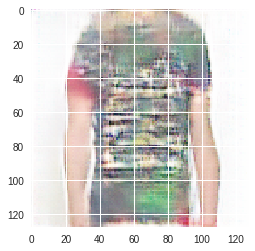

In [0]:
test('green striped')

In [0]:
input_txt=graph.get_tensor_by_name("Txt_Em:0")
a=graph.get_tensor_by_name("generator/out:0")
example_z = np.random.uniform(-1, 1, size=[1, 100])
samples=sess.run(a,feed_dict={inputs_z: example_z,input_txt:Em})
samples=np.reshape(samples,(samples.shape[1],samples.shape[1],3))
samples = cv2.cvtColor(samples, cv2.COLOR_BGR2RGB)
snap_shot_dir='drive/My Drive/Colab Notebooks/data/txt2img'
save_snapshots(samples,snap_shot_dir,'x')
x=samples
a=np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
plt.imshow(a)
#save_snapshots(sample1,snap_shot_dir,'s2')


In [0]:
text.shape

In [0]:
def test(example_z,Embeddings):
  inputs_z = tf.placeholder(tf.float32, (None, z_dim))
  inputs_txt= tf.placeholder(tf.float32,(None,txt_dim))

  model_dir='drive/My Drive/Colab Notebooks/data/txt2img/model25oct/model.ckpt'
  with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, model_dir)
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        samples = sess.run(generator(input_z, 3,input_txt, False),feed_dict={input_z: example_z,input_txt:Embeddings})
        samples=np.reshape(samples,(samples.shape[1],samples.shape[1],3))
        samples = cv2.cvtColor(samples, cv2.COLOR_BGR2RGB)
        x=samples
        a=np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
        plt.imshow(a)

In [0]:
with tf.Graph().as_default():
  Image_path='drive/My Drive/Colab Notebooks/data/txt2img/images'
  Text_path='drive/My Drive/Colab Notebooks/data/txt2img/your_file.txt'
  batch_images,Embeddings,text_list=image_batch_generator(1,Image_path,Text_path,word_em)
  print(text_list[0])
  example_z = np.random.uniform(-1, 1, size=[1, 100])
  test(example_z,Embeddings)
  

In [0]:
input_txt=graph.get_tensor_by_name("Txt_Em:0")
a=graph.get_tensor_by_name("generator/out:0")
example_z = np.random.uniform(-1, 1, size=[1, 100])
#print(text)
samples=sess.run(a,feed_dict={inputs_z: example_z,input_txt:text})

#samples=np.reshape(samples,(samples.shape[1],samples.shape[2],samples.shape[3]))
#save_snapshots(samples,snap_shot_dir,'x')
samples=np.reshape(samples,(samples.shape[1],samples.shape[1],3))
samples = cv2.cvtColor(samples, cv2.COLOR_BGR2RGB)

x=samples
a=np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
plt.imshow(a)
#save_snapshots(sample1,snap_shot_dir,'s2')


In [0]:
def image_batch_generatorx(batch_size,Image_path,text_path,word_em):
  

    idx = np.arange(1 , 1819)
    np.random.shuffle(idx)
    idx=idx[:batch_size]
    Images=[]
    text_list=[]
    Embedding_list=[]
    for name in idx:
      
      #image
      filename=str(name)+'.jpg'
      image=read_resize(Image_path,filename)
      Images.append(image)

      
      
      #text
      with open(Text_path) as fp:
        for i, line in enumerate(fp):
          if i == name:
            text,Embedding=txt_2_wordembeddingx(line,word_em)
      
      text_list.append(text)
      EM=np.asarray(Embedding)
      EM=np.reshape(EM,400)
      Embedding_list.append(EM)
    
    
    Embedding_list=np.asarray(Embedding_list)  
    Images = np.array(Images, dtype=np.float32)
    Images/=255.0
    
    return Images,Embedding_list,text_list

def txt_2_wordembeddingx(line,word_em):
  x=re.sub(r"(?<!\\)\\n|\n", "", line)
  x1=x.lower().split()
  embedding_list=[]
  text_list=[]
  for i in range(4):
    text_list.append(x1[i].lstrip())
    embedding_list.append(word_em[x1[i].lstrip()])

  return(text_list,embedding_list)

In [0]:
Images,Embedding_list,text_list=image_batch_generatorx(1,Image_path,Text_path,word_em)

In [0]:
a=np.reshape(Images,(128,128,3))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)

In [0]:
text_list